Autocorrelation Pitch Detection
=

# Technical Overview

Autocorrelation refers to the correlation of a signal with a shifted version of itself. In pitch estimation, we expect that a signal correlates strongly with a version of itself shifted by one cycle of the fundamental frequency.

We calculate the autocorrelation $r$ as follows for a signal $x$ and a shift $k$:

$$r(k) = \sum_n x_n \bar x_{n-k}$$

Note that $r(k)$ is symmetric about $k$ and maximized at $k=0$.

This is a simple formula that illustrates the idea of autocorrelation: when the signal and its $k$-shifted version are similar, we have $r(k) \approx \sum_n x_n^2$. Otherwise, the values are mismatched and therefore produce a smaller sum.

However, one main caveat for this approach is that it is sensitive to changes in overall amplitude. A more robust formula can be obtained by normalizing the data (adapted from the Pearson correlation coefficient):

$$
\begin{align*}
r(k)
&= \frac{Cov(x_n, x_{n-k})}{Var(x_n)} \\
&= \frac{\sum_{n=k+1}^N (x_n - \mu_{x_n}) (x_{n-k} - \mu_{x_n})}{\sum_n (x_n - \mu_{x_n})^2} \\
\end{align*}
$$

The algorithm implemented in the following code finds the largest frequency corresponding to the largest correlation value and returns it as the predicted fundamental frequency.

One issue to address is noise - we don't always want to assign a prediction, as the signal may be at times of just noise instead of a meaningful pitch we aim to measure. We can solve this in a few different ways:
- Threshold the correlation: categorize anything with a low enough correlation to be noise.
- Threshold based on amplitude: if the signal is not loud enough, we can predict noise.

These thresholds may need to be tuned to the environment of the recording for best results.

Finally, repeatedly 

# Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from pitch_detection_common import generate_signal, plot_signal

## Detecting pitch

In [2]:
def autocorrelate(arr, normalized=False):
    """
    Calculates autocorrelation of a signal arr.

    :param arr: input signal
    :param normalized: whether to used the normalized autocorrelation formula
    :return: autocorrelation of the signal
    """
    n = len(arr)
    # pad with zeros
    padded_arr = np.pad(arr, (0, n), 'constant')

    r = None
    if normalized:
        variance = np.var(arr)
        r = np.array([
            np.cov(np.vstack([arr, padded_arr[k:n+k]]))[0, 1] / variance
            for k in range(n)
        ])
    else:
        r = np.array([
            np.sum(arr * np.conj(padded_arr[k:n+k]))
            for k in range(n)
        ])

    return r

Magnitudes: [0.36787944 0.64118039 0.89483932 1.         0.89483932 0.64118039
 0.36787944]
0 441


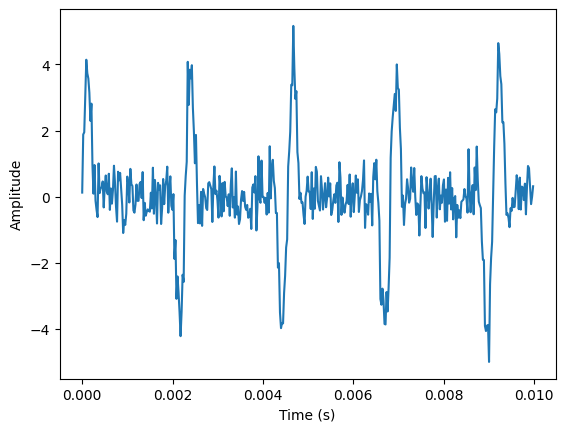

In [3]:
fs = 44100
T = 0.5

simple_synthetic = generate_signal(
    440,
    shape="bump",
    noise_level=0.5,
    duration=T,
    fs=fs,
    n=7,
    sigma=1,
    bump_max=1,
    verbose=True)

plot_signal(simple_synthetic, start=0, duration=0.01)

C:\Users\emily\AppData\Local\Temp\ipykernel_48016\3541533104.py:6: RuntimeWarning: divide by zero encountered in divide
  frequencies = 1 / time_delays # in Hz


Text(0.5, 1.0, 'autocorrelation')

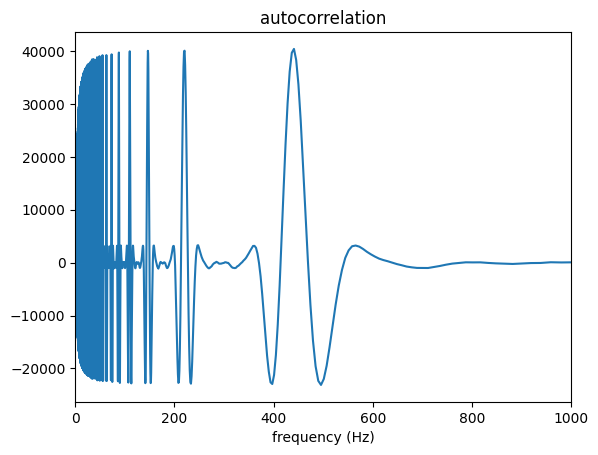

In [4]:
result = autocorrelate(simple_synthetic, normalized=False)

# make x axis hz instead of samples
lags = np.arange(len(result)) # in samples
time_delays = lags / fs # in seconds
frequencies = 1 / time_delays # in Hz

fig, ax = plt.subplots()
ax.plot(frequencies, result)
ax.set_xlim(0, 1000)
ax.set_xlabel('frequency (Hz)')
ax.set_title('autocorrelation')

In [5]:
# find a peak, not at 0
predicted_f0 = frequencies[np.argmax(result[10:]) + 10]
print(f"Predicted f0: {predicted_f0} Hz")

Predicted f0: 441.0 Hz


C:\Users\emily\AppData\Local\Temp\ipykernel_48016\268300399.py:6: RuntimeWarning: divide by zero encountered in divide
  frequencies = 1 / time_delays # in Hz


Text(0.5, 1.0, 'autocorrelation')

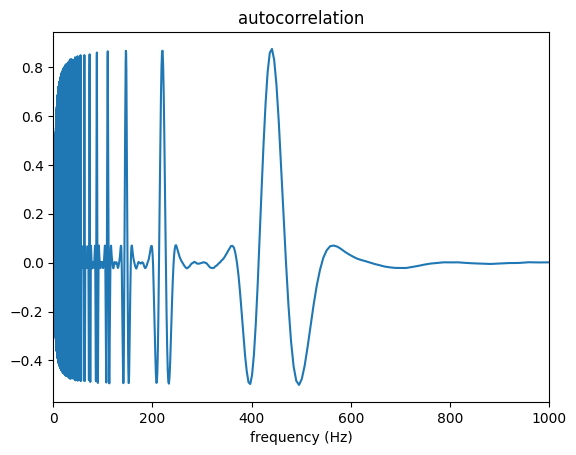

In [6]:
result = autocorrelate(simple_synthetic, normalized=True)

# make x axis hz instead of samples
lags = np.arange(len(result)) # in samples
time_delays = lags / fs # in seconds
frequencies = 1 / time_delays # in Hz

fig, ax = plt.subplots()
ax.plot(frequencies, result)
ax.set_xlim(0, 1000)
ax.set_xlabel('frequency (Hz)')
ax.set_title('autocorrelation')

## Extending to windows

In [7]:
class AutocorrelationPitchEstimator:
    def __init__(self, signal, fs=44100, fmin=50, fmax=1200):
        self.signal = signal
        self.signal64 = signal.astype(np.int64)
        self.fs = fs
        self.fmin = fmin
        self.fmax = fmax
    
    def autocorrelate(self, arr, normalized=False):
        """
        Calculates autocorrelation of a signal arr.

        :param arr: input signal
        :param normalized: whether to used the normalized autocorrelation formula
        :return: autocorrelation of the signal
        """
        n = len(arr)
        # pad with zeros
        padded_arr = np.pad(arr, (0, n), 'constant')

        r = None
        if normalized:
            variance = np.var(arr)
            r = np.array([
                np.cov(np.vstack([arr, padded_arr[k:n+k]]))[0, 1] / variance
                for k in range(n)
            ])
        else:
            r = np.array([
                np.sum(arr * np.conj(padded_arr[k:n+k]))
                for k in range(n)
            ])

        return r

    def estimate_pitch(self, window_size=1024, hop_size=512, r_threshold=0.85, rms_threshold=3000, plot=False, plot_correlation=False):
        """
        Estimates pitch of the signal using autocorrelation.

        :param window_size: window size for the autocorrelation
        :return: estimated pitch
        """
        pitches = []
        correlation = []
        rms = []

        for i in range(0, len(self.signal) - window_size, hop_size):
            window = self.signal[i:i+window_size]
            window64 = self.signal64[i:i+window_size]
            r = self.autocorrelate(window, normalized=True)

            ind_min = int(self.fs / self.fmax)
            ind_max = int(self.fs / self.fmin)

            r[:ind_min] = 0
            r[ind_max:] = 0

            peak_index = np.argmax(r[ind_min:ind_max]) + ind_min

            pitch = self.fs / peak_index if peak_index > 0 else 0
            pitches.append(pitch)
            correlation.append(r[peak_index])
            rms.append(np.sqrt(np.mean(window64 ** 2)))

        time = np.arange(len(pitches)) * hop_size / self.fs

        pitches = np.array(pitches)
        correlation = np.array(correlation)
        rms = np.array(rms)

        # thresholding by correlation
        pitches[correlation < r_threshold] = 0

        # thresholding by root mean squared
        pitches[rms < rms_threshold] = 0
        
        if plot:
            fig, ax = plt.subplots()
            ax.plot(time, pitches)
            ax.set_xlabel('time (s)')
            ax.set_ylabel('frequency (Hz)')
            ax.set_title('pitch estimation')

            # shade places where correlation is below threshold
            for i in range(len(correlation)):
                if correlation[i] < r_threshold:
                    ax.axvspan(i * hop_size / self.fs, (i + 1) * hop_size / self.fs, color='red', alpha=0.1)
            
            # do the same for rms but in blue
            for i in range(len(rms)):
                if rms[i] < rms_threshold:
                    ax.axvspan(i * hop_size / self.fs, (i + 1) * hop_size / self.fs, color='blue', alpha=0.1)
        
        if plot_correlation:
            fig, ax = plt.subplots()
            ax.plot(time, correlation)
            ax.set_xlabel('time (s)')
            ax.set_ylabel('correlation')
            ax.set_title('correlation')
        
        return time, pitches, correlation


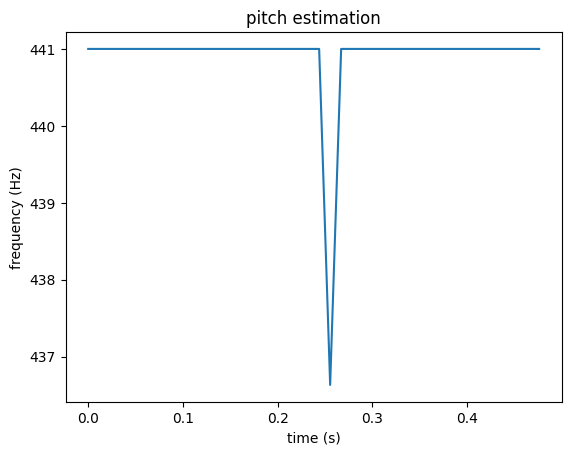

In [8]:
simple_estimator = AutocorrelationPitchEstimator(simple_synthetic, fs)
pitches = simple_estimator.estimate_pitch(plot=True, r_threshold=0, rms_threshold=0)

0 17640


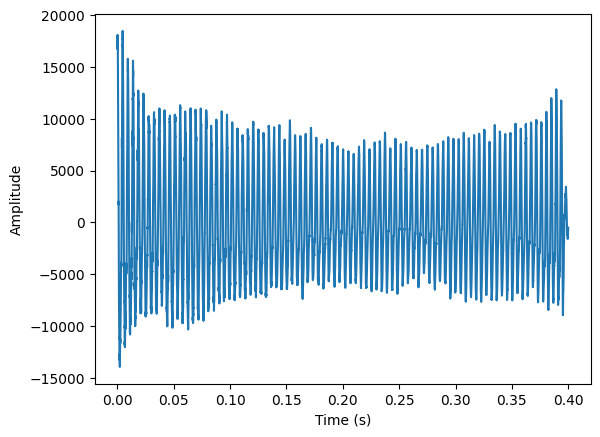

In [9]:
# load some samples to try
ocarina_fs, ocarina_sample = wav.read('../data/ocarina_scale.wav')
violin_fs, violin_sample = wav.read('../data/violin_scale.wav')
violin_pizz_fs, violin_pizz_sample = wav.read('../data/violin_pizz_scale.wav')
whistle_fs, whistle_sample = wav.read('../data/whistle_zelda.wav')

# convert to mono
ocarina_sample = ocarina_sample.mean(axis=1)
violin_sample = violin_sample.mean(axis=1)
violin_pizz_sample = violin_pizz_sample.mean(axis=1)
whistle_sample = whistle_sample.mean(axis=1)

piranha_fs, piranha_sample = wav.read('../data/piranha_plant_sample.wav')
piranha_sample_short = piranha_sample[int(0.6 * piranha_fs):int(1 * piranha_fs)]
plot_signal(piranha_sample_short, start=0)

Predicted f0: 217.24137931034483 Hz


C:\Users\emily\AppData\Local\Temp\ipykernel_48016\613325000.py:5: RuntimeWarning: divide by zero encountered in divide
  frequencies = fs / lags


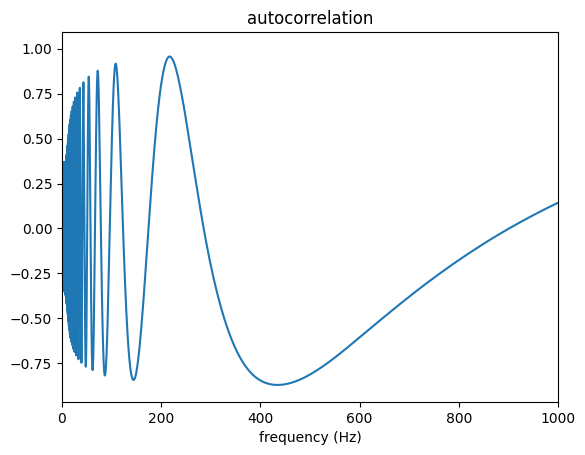

In [10]:
result = autocorrelate(piranha_sample_short, normalized=True)

# make x axis hz instead of samples
lags = np.arange(len(result)) # in samples
frequencies = fs / lags

fig, ax = plt.subplots()
ax.plot(frequencies, result)
ax.set_xlim(0, 1000)
ax.set_xlabel('frequency (Hz)')
ax.set_title('autocorrelation')

predicted_f0 = frequencies[np.argmax(result[10:]) + 10]
peak = np.argmax(result[10:]) + 10
predicted_f0 = fs / peak
print(f"Predicted f0: {predicted_f0} Hz")

(array([0.        , 0.01160998, 0.02321995, 0.03482993, 0.04643991,
        0.05804989, 0.06965986, 0.08126984, 0.09287982, 0.1044898 ,
        0.11609977, 0.12770975, 0.13931973, 0.15092971, 0.16253968,
        0.17414966, 0.18575964, 0.19736961, 0.20897959, 0.22058957,
        0.23219955, 0.24380952, 0.2554195 , 0.26702948, 0.27863946,
        0.29024943, 0.30185941, 0.31346939, 0.32507937, 0.33668934,
        0.34829932]),
 array([218.31683168, 216.17647059, 217.24137931, 218.31683168,
        218.31683168, 217.24137931, 216.17647059, 216.17647059,
        216.17647059, 216.17647059, 216.17647059, 215.12195122,
        215.12195122, 213.04347826, 212.01923077, 212.01923077,
        214.0776699 , 216.17647059, 216.17647059, 215.12195122,
        214.0776699 , 213.04347826, 215.12195122, 218.31683168,
        218.31683168, 219.40298507, 218.31683168, 218.31683168,
        218.31683168, 219.40298507, 222.72727273]),
 array([0.85564045, 0.86464062, 0.88397079, 0.89971778, 0.90020456,
  

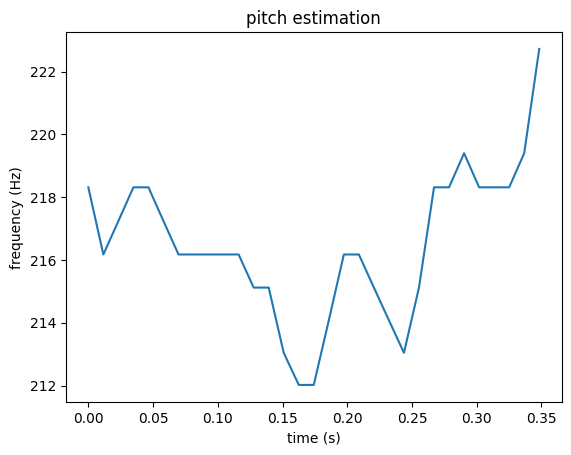

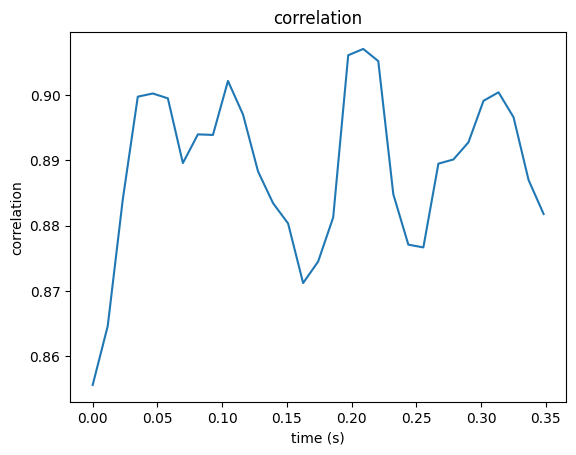

In [11]:
piranha_estimator = AutocorrelationPitchEstimator(piranha_sample_short, piranha_fs)
piranha_estimator.estimate_pitch(window_size=2048, hop_size=512, plot=True, plot_correlation=True)

C:\Users\emily\AppData\Local\Temp\ipykernel_48016\1093419496.py:25: RuntimeWarning: invalid value encountered in scalar divide
  np.cov(np.vstack([arr, padded_arr[k:n+k]]))[0, 1] / variance


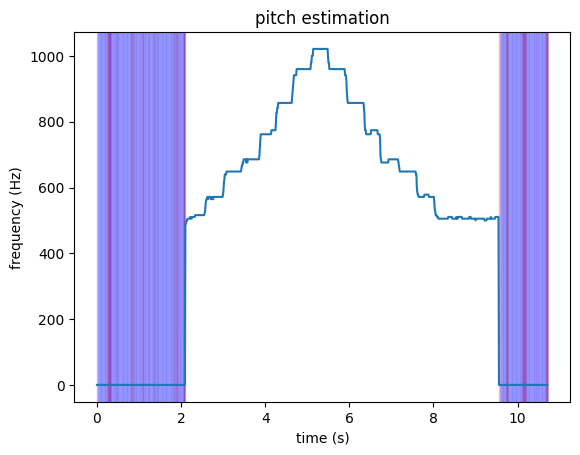

In [12]:
ocarina_estimator = AutocorrelationPitchEstimator(ocarina_sample, ocarina_fs)
time, pitches, correlation = ocarina_estimator.estimate_pitch(window_size=2048, hop_size=512, rms_threshold=1000, plot=True)

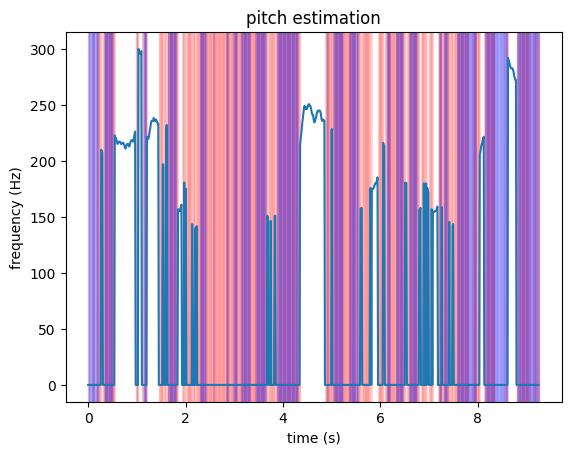

In [13]:
piranha_estimator_full = AutocorrelationPitchEstimator(piranha_sample, piranha_fs)
time, pitches, correlation = piranha_estimator_full.estimate_pitch(window_size=2048, hop_size=512, plot=True)

C:\Users\emily\AppData\Local\Temp\ipykernel_48016\1093419496.py:25: RuntimeWarning: invalid value encountered in scalar divide
  np.cov(np.vstack([arr, padded_arr[k:n+k]]))[0, 1] / variance


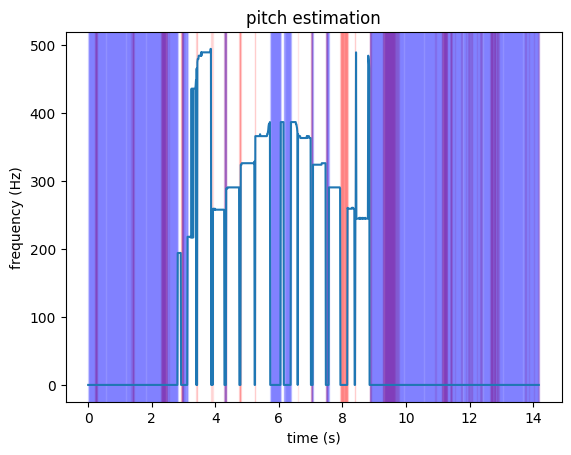

In [14]:
violin_estimator = AutocorrelationPitchEstimator(violin_sample, violin_fs)
time, pitches, correlation = violin_estimator.estimate_pitch(window_size=2048, hop_size=512, plot=True)

# References

- https://econ.queensu.ca/ETM/corrections/Third-pdf/pg564-5.pdf
- https://musicinformationretrieval.com/autocorrelation.html
- https://numpy.org/doc/stable/reference/generated/numpy.correlate.html